In [1]:
#Data manipulation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, CountVectorizer

#Sentiment Analysis
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
url="../data/E-Commerce_Reviews.csv"
df = pd.read_csv(url)
print(df.shape)

(23486, 11)


### 3. Cleaning up the dataset

#### 3.1 Initial Data Inspection
To start with the cleaning process, a quick look once over of the dataset is useful to identify any outliers.

In [3]:
df.sample(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
14283,14283,139,53,NaN,"Great layering top. so comfy, feels soft as my...",5,1,0,Initmates,Intimate,Layering
15611,15611,867,47,NaN,NaN,5,1,0,General Petite,Tops,Knits
5162,5162,818,54,Beautiful detail,I love this top. it comes with its own camisol...,5,1,3,General Petite,Tops,Blouses
21723,21723,895,33,So very pretty,"This is such a classy, elegant and interest pi...",5,1,1,General Petite,Tops,Fine gauge
23172,23172,1094,30,Great!!!!,I purchased this dress in the raspberry for my...,5,1,0,General,Dresses,Dresses


The data set contains 23,486 rows of data. At first glance, the dataset has one column that appears to contain redundant index information. The following code is to drop that column.

In [4]:
#we drop the unnamed because it`s a duplicate`
df = df.drop(columns = "Unnamed: 0")

In addition, the column names could be improved by converting to snake case without spaces separated by an underscore, and all letters in lowercase.

In [5]:
df.columns = (df.columns
                .str.replace(' ', '_')
                .str.lower()
             )
print(df.columns)

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')


#### 3.2 Handling Missing Values
Also, another good practice is to give a check on how many null values there are in the dataset.¶
Note: I personally like doing this before converting the objects into strings to avoid converting NA values into actual strings.

In [6]:
df.isna().sum() 

clothing_id                   0
age                           0
title                      3810
review_text                 845
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
dtype: int64

Most of the null values are concentrated in the title column. Because we will not be working with this column during the analysis, this does not affect the results. The number of null values in review_text is also significant but this will be addressed in the next block of code

In [7]:
rows_with_na = df[df['review_text'].isna()]
print(rows_with_na)

       clothing_id  age title review_text  rating  recommended_ind   
92             861   23   NaN         NaN       5                1  \
93            1081   31   NaN         NaN       5                1   
98            1133   50   NaN         NaN       5                1   
135            861   35   NaN         NaN       4                1   
142           1126   35   NaN         NaN       5                1   
...            ...  ...   ...         ...     ...              ...   
23258          862   35   NaN         NaN       4                1   
23301          862   52   NaN         NaN       5                1   
23303          823   46   NaN         NaN       5                1   
23470         1104   39   NaN         NaN       5                1   
23480          862   35   NaN         NaN       5                1   

       positive_feedback_count   division_name department_name class_name  
92                           0  General Petite            Tops      Knits  
93     

The following code displays the rows of reviews that are empty (all these coincide with having an empty title as well). Out of the total 23,486 actual rows, 845 have null values on review_text and 3810 null titles. So by removing the empty review_texts rows we reduce the instances of null titles as well. Also, because the analysis is mostly based on review_text, the Nan values on title have no impact on our analysis.¶
The way of dealing with null values will be different depending on the data we are handling and the purpose of the analysis. In this case, I'd like to know what percentage of the dataset these null values on reviews represent.

In [8]:
rows_with_na = df[df['review_text'].isna()]
print(rows_with_na)

       clothing_id  age title review_text  rating  recommended_ind   
92             861   23   NaN         NaN       5                1  \
93            1081   31   NaN         NaN       5                1   
98            1133   50   NaN         NaN       5                1   
135            861   35   NaN         NaN       4                1   
142           1126   35   NaN         NaN       5                1   
...            ...  ...   ...         ...     ...              ...   
23258          862   35   NaN         NaN       4                1   
23301          862   52   NaN         NaN       5                1   
23303          823   46   NaN         NaN       5                1   
23470         1104   39   NaN         NaN       5                1   
23480          862   35   NaN         NaN       5                1   

       positive_feedback_count   division_name department_name class_name  
92                           0  General Petite            Tops      Knits  
93     

In [9]:
total_rows = len(df)
missing_rows = df['review_text'].isna().sum()

percentage_missing = (missing_rows / total_rows) * 100
print(f'Percentage of Missing Values: {percentage_missing:.2f}%')

Percentage of Missing Values: 3.60%


Next step would be to drop rows with missing values from Reviews.

In [10]:
df = df.dropna(subset=['review_text'])

In addition, the 14 Nan values appearing in division_name are going to be removed, this will probably also resolve the Nan of department_name and class_name.

In [11]:
df = df.dropna(subset=['division_name'])

In [12]:
df.isna().sum() 

clothing_id                   0
age                           0
title                      2966
review_text                   0
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                 0
department_name               0
class_name                    0
dtype: int64

#### 3.3 Checking for Duplicates
The following code evaluates each column of the DataFrame to identify rows containing identical data. The outcome marks duplicates as True while the first occurrence of any duplicate row remains unmarked (ex. False)

In [13]:
df[df.duplicated()]
#Note to self: Why double df[]? Because in order to get it filtered by the boolean indexing.

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
21888,1022,37,NaN,"Love, love these jeans. being short they come ...",5,1,0,General,Bottoms,Jeans


Since only one duplicate entry was found in the dataset, it has been removed from the DataFrame.

In [14]:
df = df.drop_duplicates()

#### 3.4 Data Type Optimization

Identifying data types in order to find mismatches and correctly setting data types is important for effective data cleaning and analysis.

In [15]:
df.dtypes

clothing_id                 int64
age                         int64
title                      object
review_text                object
rating                      int64
recommended_ind             int64
positive_feedback_count     int64
division_name              object
department_name            object
class_name                 object
dtype: object

Object data types can be memory-intensive, especially if the column contains long strings or if there are many unique string values. In contrast, using more specific data types like int or category can save memory and improve performance
Additionally, to identify categorical data, obtaining unique values from columns classified as 'Object' types is an effective method for detection.

In [16]:
unique_division_name = df['division_name'].unique()
unique_department_name = df['department_name'].unique()
unique_class_name = df['class_name'].unique()

print("Unique values in the unique_division_name:", unique_division_name)

print("Unique values in the unique_department_name:", unique_department_name)

print("Unique values in the unique_class_name:", unique_class_name)

Unique values in the unique_division_name: ['Initmates' 'General' 'General Petite']
Unique values in the unique_department_name: ['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend']
Unique values in the unique_class_name: ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In this case, we could see there are some mispelled words like ¨Intimates¨ and replace the wrong ones.

In [17]:
df['division_name'] = df['division_name'].str.replace('Initmates', 'Intimates')
df['department_name'] = df['department_name'].str.replace('Intimate', 'Intimates')

Converting category columns into Category data type.

In [18]:
df['division_name'] = df['division_name'].astype('category')
df['department_name'] = df['department_name'].astype('category')
df['class_name'] = df['class_name'].astype('category')

In [19]:
df['recommended_ind'].unique()

array([1, 0], dtype=int64)

Checking on how our new dataframe columns’ types look.

In [20]:
df.dtypes

clothing_id                   int64
age                           int64
title                        object
review_text                  object
rating                        int64
recommended_ind               int64
positive_feedback_count       int64
division_name              category
department_name            category
class_name                 category
dtype: object

#### 3.5 Age validation test

In [21]:
min_age = df['age'].min()
max_age = df['age'].max()

if (min_age>18 & max_age<99):
    print(f"Test passed: Age goes from {min_age} to {max_age} which makes sense.")
else:
    print(f"Test not passed, age goes from {min_age} to {max_age} ")

Test passed: Age goes from 18 to 99 which makes sense.


#### 3.6 Data Index Reset
It's often a good idea to reset the index for clarity and consistency, especially if the DataFrame will be used for further transformations or analyses.

In [22]:
df.reset_index(drop=True, inplace=True) 
#Note to self: inplace=True to avoid adding the old index as a new column

### 4 Exploratory Data Analysis (EDA)

#### 4.1 Qualitative Analysis
Dataset's structure: To gain a more comprehensive insight into the organization of the dataframe, a pivot table is utilized. This tool effectively illustrates the hierarchical arrangement of departments within divisions, providing a clear view of the dataset's structure.

In [23]:
pivot_table = pd.pivot_table(df, values='class_name', index=['division_name', 'department_name'], #lists unique class names for each department
                             aggfunc=lambda x: x.unique())

display(pivot_table)

class_name
division_name  department_name                                                   
General        Bottoms          ['Pants', 'Skirts', 'Jeans', 'Shorts', 'Casual...
               Dresses          ['Dresses']
Categories (20, object): ['Blouses...
               Jackets          ['Outerwear', 'Jackets']
Categories (20, objec...
               Tops             ['Blouses', 'Sweaters', 'Knits', 'Fine gauge']...
               Trend            ['Trend']
Categories (20, object): ['Blouses',...
General Petite Bottoms          ['Pants', 'Skirts', 'Jeans']
Categories (20, o...
               Dresses          ['Dresses']
Categories (20, object): ['Blouses...
               Intimates        ['Lounge']
Categories (20, object): ['Blouses'...
               Jackets          ['Jackets', 'Outerwear']
Categories (20, objec...
               Tops             ['Knits', 'Blouses', 'Fine gauge', 'Sweaters']...
               Trend            ['Trend']
Categories (20, object): ['Blouses',...
Intimates      Intimates        ['Intimates', 'Lounge', 'Sleep', 'Swim', 'Legw...

The dataset is structured into three primary divisions: General, General Petite, and Intimates. Each of these divisions encompasses various departments, which are further categorized into classes.¶
General Division: This division includes a range of departments such as Bottoms, Dresses, Jackets, Tops, and Trend.
1. The Bottoms department features classes like Pants, Skirts, Jeans, Shorts, and Casual Bottoms.
2. The Dresses department is singularly classified as Dresses.
3. In the Jackets department, you find classes like Outerwear and Jackets.
4. The Tops and Trend departments have their respective unique classes.

General Petite Division: This division mirrors the General division with departments like Bottoms, Dresses, Jackets, Tops, and Trend. Additionally, it includes the Intimates department. Similar to the General division, the Bottoms, Dresses, Jackets, Tops, and Trend departments in General Petite have corresponding classes. The Intimates department under General Petite features specific classes pertinent to this category.¶
Intimates Division: The Intimates division is more specialized and contains a single department, Intimates, which encompasses various classes tailored to intimate apparel.
To make this analysis more efficient, during the EDA phase we will explore the relationships between variables, and we will exclude department_name from the analysis, using only division_name and class_name as Product Type.

#### 4.2 Quantitative Analysis

##### 4.2.1 Reviews distributions per Division and Ratings

In the following analysis I aim to get a deeper understanding on the Customers' reviews for the Divisions: General, General Petite and Intimates. This offers some insight into the clothing sizes of the customers leaving reviews. Also, the nature of Customers' satisfaction with their purchases.
This block of code allows plotting 2 graphs on the same line. Enumerating the loop enables the loop iteration to coincide with the matplotlib subplot axes

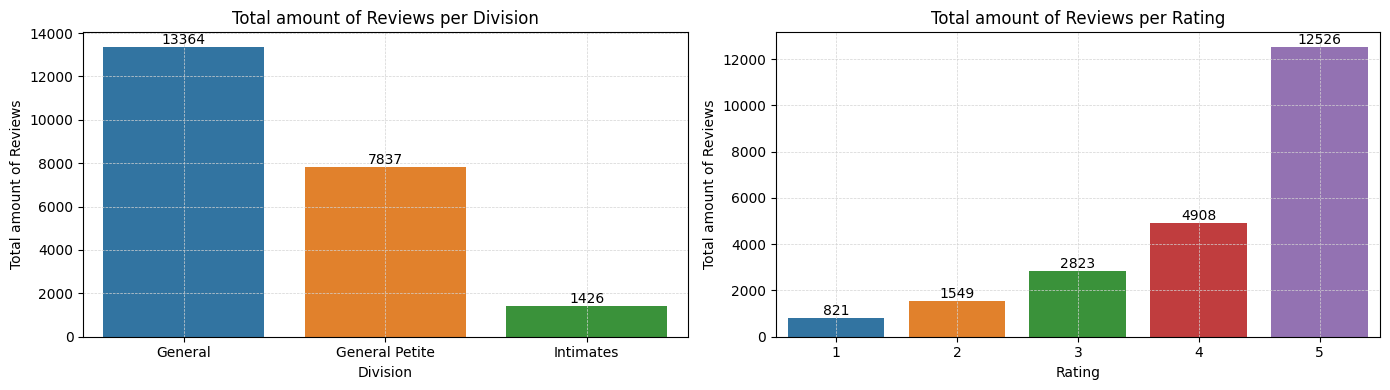

In [24]:
row_plots = ["division_name", "rating"]

f, axes = plt.subplots(1, len(row_plots), figsize=(14, 4), sharex=False) # Create a figure and a set of subplots

# First plot: Total amount of Reviews per Division
division_counts = df['division_name'].value_counts().sort_index()
sns.barplot(x=division_counts.index, y=division_counts.values, ax=axes[0])

for i, count in enumerate(division_counts.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

axes[0].set_xlabel('Division')
axes[0].set_ylabel('Total amount of Reviews')
axes[0].set_title('Total amount of Reviews per Division')
axes[0].grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0)

# Second plot: Total amount of Reviews per Rating
rating_counts = df['rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[1])

for i, count in enumerate(rating_counts.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Total amount of Reviews')
axes[1].set_title('Total amount of Reviews per Rating')
axes[1].grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0)

plt.tight_layout()
plt.show()

In terms of Divisions, customers predominantly buy from the General division, General Petite in second place and Intimates in third place.
The displayed plot reveals a concentration of customer reviews primarily in the 5 rating category, indicating that the dataset is predominantly positive in nature.

In [25]:
percentage_5_stars = (df['rating'] == 5).sum() * 100 / len(df)
print(f'5 stars ratings represent {percentage_5_stars:.2f}% of the dataframe')

5 stars ratings represent 55.36% of the dataframe


##### 4.2.2 Ratings distribution per class_name or Type of product


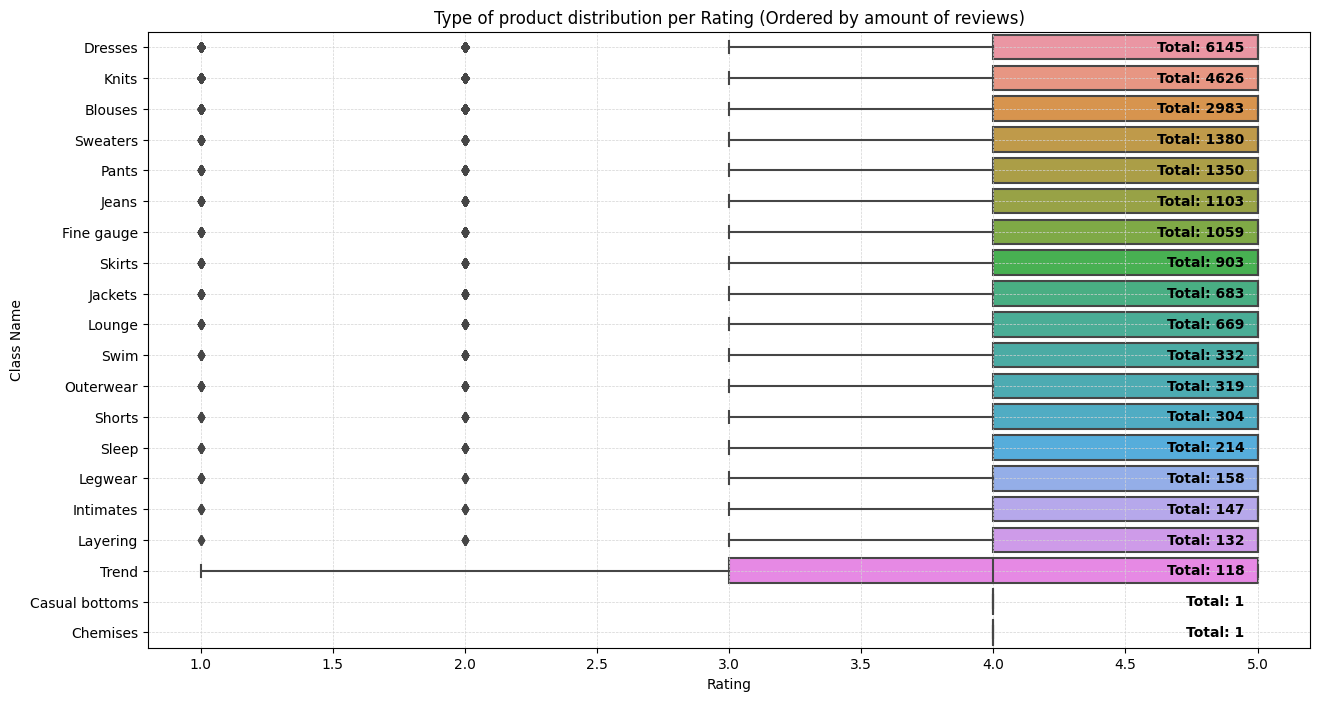

In [26]:
medians = df.groupby('class_name')['rating'].count().sort_values(ascending=False) #median values per group

sorted_names = medians.index.tolist() #order by medians

plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=df['rating'], y=df['class_name'], order=sorted_names)

plt.xlabel('Rating')
plt.ylabel('Class Name')

x_max = ax.get_xlim()[1]

for i, class_name in enumerate(sorted_names):
    count = medians[class_name]
    ax.text(x_max -0.25, i, f'Total: {count}', va='center', color='black', fontweight='bold', ha='right') #total count of reviews

plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0) 
plt.title('Type of product distribution per Rating (Ordered by amount of reviews)')
plt.show()

Despite the division and departmental categories, this plot aims to analyze a general view of clothes per class. Displaying the distribution of the ratings, this boxplot makes it easy to detect outliers and which classes have the lower general rating. Totals are showing the total number of reviews per class.
The most common rating in this plot is the highest possible rating (5) with a distribution of the ratings left-skewed,indicating a an overall satisfaction with most of the products and with a couple of outliers located in ratings 1 and 2.
Trend as a class seems to have the lower minimum values. To get further information a quick describe table will be displayed

Another relevant characteristic is that Casual bottoms and Chemises have only one review per Class

In [27]:
one_review = df[(df['class_name'] == 'Casual bottoms') | (df['class_name'] == 'Chemises')]
display(one_review)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
11952,45,26,"Cute pants, but short.",These pants have a really cute design. however...,4,1,0,General,Bottoms,Casual bottoms
12946,10,38,Comfy and cute,This dress is comfortable and a great piece to...,4,1,0,Intimates,Intimates,Chemises


About Casual bottoms, in this case there is only one pair of pants which should be included in 'Pants' Class.¶
For Chemises, it appears to be a misclassification of the source. The review describes shoes that go well with the product, in this case a dress, implying that it is a dress for going out and not a product that would be part of the Intimates category

In [28]:
casual_b = df[(df['class_name'] == 'Casual bottoms')]
chemises = df[(df['class_name'] == 'Chemises')]

indices_to_change = list(casual_b.index) + list(chemises.index) #indices combined in a singles list

new_class_names = ['Pants', 'Dresses']

for i in range(len(indices_to_change)):
    index = indices_to_change[i]
    new_class_name = new_class_names[0] if i < len(casual_b) else new_class_names[1]
    df.at[index, 'class_name'] = new_class_name

Successfully recategorized those 2 cases.

In [29]:
grouped_data = df.groupby('class_name')['rating'].describe()

filtered_data = grouped_data[grouped_data['count'] > 0]

sorted_data = filtered_data.sort_values(by=('mean'))

display(sorted_data) 

,count,mean,std,min,25%,50%,75%,max
class_name,,,,,,,,
Trend,118.0,3.838983,1.313769,1.0,3.0,4.0,5.0,5.0
Dresses,6146.0,4.138789,1.127554,1.0,4.0,5.0,5.0,5.0
Blouses,2983.0,4.142809,1.140846,1.0,4.0,5.0,5.0,5.0
Knits,4626.0,4.145698,1.121563,1.0,4.0,5.0,5.0,5.0
Sweaters,1380.0,4.168841,1.134104,1.0,4.0,5.0,5.0,5.0
Swim,332.0,4.171687,1.125392,1.0,4.0,5.0,5.0,5.0
Outerwear,319.0,4.181818,1.129165,1.0,4.0,5.0,5.0,5.0
Skirts,903.0,4.229236,1.095014,1.0,4.0,5.0,5.0,5.0
Fine gauge,1059.0,4.237960,1.079117,1.0,4.0,5.0,5.0,5.0


This table shows the class statistics sorted by average. Leading the way is Trend with a total of 118 opinions and an average of 3.83. This class is well below the rest, with a mean well below the rest of the classes. The rest of the classes have a spectrum of averages from 4.13 to 4.34. The minimum value of all classes is 1.¶

In [30]:
df_trend_class = df[df['class_name'] == 'Trend']


In [31]:
unique_clothing_ids = df_trend_class['clothing_id'].nunique()

total_reviews = df_trend_class['rating'].count()

print(f"Trend class - Unique Clothing IDs: {unique_clothing_ids}")
print(f"Trend class - Total Reviews: {total_reviews}")

Trend class - Unique Clothing IDs: 38
Trend class - Total Reviews: 118


As we saw previously, the standard distribution of the dataframe is to have 50% of reviews at a 5.0 rating and a mean higher than 4.13. To find where the lowest ratings for the Trend class are located, I'm grouping the 118 reviews by the 42 unique products (by clothing_id) in this class and plotting a boxplot filtered by a mean of 4.13 to expose a non-standard distribution.

In [32]:
grouped_data = df_trend_class.groupby('clothing_id')['rating'].describe()

filtered_data = grouped_data[grouped_data['mean'] < 4.13]

df_filtered_trends = filtered_data.sort_values(by=('mean'))

total_unique_clothing_ids = df_filtered_trends.shape[0]
total_reviews = df_filtered_trends['count'].sum()

print(f"Trend class - Products with a mean < 4.13 - Total Unique Clothing IDs: {total_unique_clothing_ids}")
print(f"Trend class - Products with a mean < 4.13 - Total Reviews: {total_reviews}")

Trend class - Products with a mean < 4.13 - Total Unique Clothing IDs: 20
Trend class - Products with a mean < 4.13 - Total Reviews: 68.0


With a total of 20 products with a mean under 4.13 representing 57% of the total Trend reviews explaining the reasons for this class to have a lower mean than the rest. The reasons of it will be explore in the Sentiment analysis section.

##### 4.2.3 Review distribution by Age

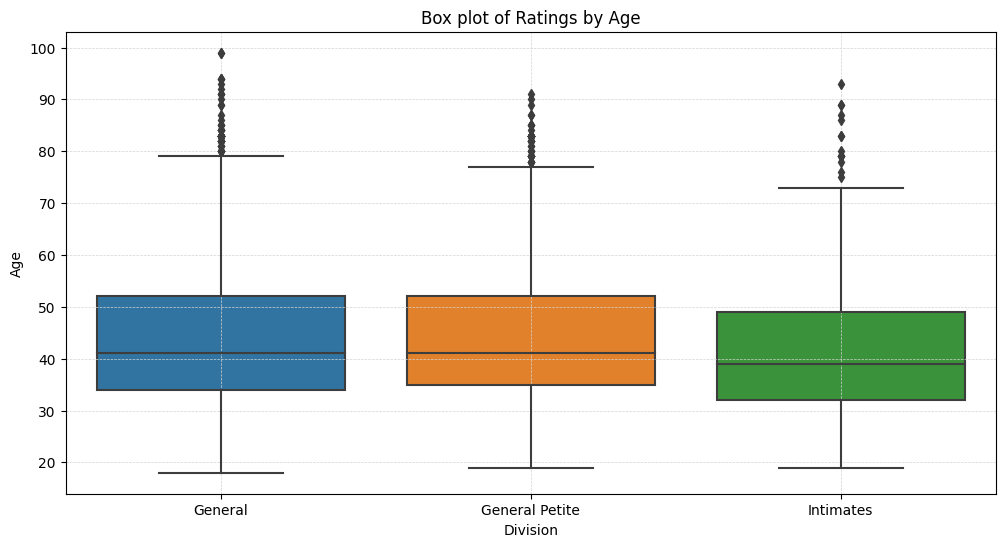

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='division_name', y='age')
plt.title('Box plot of Ratings by Age')
plt.xlabel('Division')
plt.ylabel('Age')
plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0) 
plt.show()

General has a median in 41 years, with an oldest outlier of 100 years old. Meanwhile, General Petite has the same mean but the oldest outlier is 91 years old. Also, the distribution of Age per division shows us that the Intimates division has a generally young audience age, with a mean of 39 years old and the Q3 (75%) is younger than 50 years. This is the youngest of all 3 divisions.

##### 4.2.4 Case Study: 100 products with the lowest average ratings
I will now undertake a case study to identify the 100 products with the lowest average ratings. This will be achieved by grouping the products by their clothing_id and calculating the mean rating for each. This approach will allow us to pinpoint the products with the lowest average ratings.¶
The first thing to do is to group the ratings per product in order to get the mean of each of them, as well as counting the amount of ratings and counting the ones with rating = 1. In these first lines of code I won’t filter the results, because it could be useful to retain all the available data for now, in case we want to do any other similar inquiries later.¶

In [34]:
ratings_per_product = df.groupby('clothing_id').agg(
    avg_rating=('rating', 'mean'),
    count_ratings=('rating', 'size'),
    count_ones=('rating', lambda x: (x == 1).sum())  # Count reviews with rating of 1
)

With the total data grouped by the amount of ratings, the following code filters by products with more than one rating = 1 and filters the 100 lowest average ratings.
Using df.nsmallest(), a function that returns the first N occurrences ordered by a particular column in ascending order.

In [35]:
filter_higher_one = ratings_per_product[ratings_per_product['count_ones'] > 1]
N = 100
filter_lowest_avg = filter_higher_one.nsmallest(N, 'avg_rating')

#display(filter_lowest_avg)

In [36]:
pd.set_option('display.max_colwidth', None)

In [37]:
display(filter_lowest_avg)

,avg_rating,count_ratings,count_ones
clothing_id,,,
973,1.000000,2,2
569,1.800000,5,2
588,2.000000,4,2
229,2.181818,11,4
1039,2.888889,9,2
...,...,...,...
1059,4.285714,287,8
1009,4.289157,83,3
850,4.290123,324,8


The previous table shows grouped per product, an average rating, the total reviews per product and a count of total '1-star' reviews', this results will be explore deeper on the Business Insights section.

#### 5 Sentiment analysis 

##### 5.1 Overview of TextBlob and VADER Tools
As mentioned in the introduction, Textblob and Vader will be compared to enrich the analysis. First, I'm running a simple test to know how they work.

In [38]:
analyzer = SentimentIntensityAnalyzer() # loading Vader 

text = "This is a good example of VADER sentiment analysis"

vader_sentiment_scores = analyzer.polarity_scores(text)

print("Positive:", vader_sentiment_scores['pos'])
print("Negative:", vader_sentiment_scores['neg'])
print("Neutral:", vader_sentiment_scores['neu'])
print("Compound:", vader_sentiment_scores['compound'])

Positive: 0.266
Negative: 0.0
Neutral: 0.734
Compound: 0.4404


In [39]:
text_blob = TextBlob("This is a good example of a TextBlob")
sentiment_blob = text_blob.sentiment

polarity_blob = sentiment_blob.polarity
subjectivity_blob = sentiment_blob.subjectivity

print("TextBlob Polarity:", polarity_blob)
print("TextBlob Subjectivity:", subjectivity_blob)

TextBlob Polarity: 0.7
TextBlob Subjectivity: 0.6000000000000001


We have two different sentiment analysis tools providing sentiment scores for two similar statements.

**TextBlob**: It provides polarity and subjectivity scores. In Example 1, the polarity score is 0.7, indicating a positive sentiment, and the subjectivity score is 0.6, indicating a moderate level of subjectivity.

**Vader**: It provides positive, negative, neutral, and compound scores. In Example 2, the compound score is 0.6369, which suggests a positive sentiment. The positive score (0.458) is the highest, indicating a positive sentiment.
Both tools generally agree on the sentiment of the given statements, classifying them as positive. However, the exact numeric scores may differ because each tool employs its own sentiment analysis algorithms and scoring systems. Additionally, TextBlob provides a subjectivity score, which VADER does not include in its output.

#### 5.2 Integration of Sentiment Analysis in the Dataset
##### 5.2.1 Adding Textblob and Vader to the dataframe


In [40]:
desc_blob = [TextBlob(desc) for desc in df['review_text']] 

In [41]:
#TEXTBLOB sentiment metrics into the dataframe
df['tb_pol'] = [b.sentiment.polarity for b in desc_blob]
df['tb_subj'] = [b.sentiment.subjectivity for b in desc_blob]

#VADER metrics into dataframe
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['review_text']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['review_text']]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df['review_text']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['review_text']]

##### 5.2.2 Displaying a selection of columns to understand behavior

In [42]:
selected_columns = ['clothing_id', 'review_text', 'rating', 'recommended_ind', 'tb_pol',
                    'tb_subj', 'compound', 'neg', 'neu', 'pos']

columns_to_highlight = ['rating', 'compound', 'tb_pol']

styled_df = df[selected_columns].head(10).style.hide(axis="index") \
                    .format({"tb_pol": "{:.2f}",
                             'tb_subj': "{:.2f}",
                             "compound": "{:.2f}",
                             "neg": "{:.2f}",
                             "neu": "{:.2f}",
                             "pos": "{:.2f}"}) \
                    .background_gradient(cmap='RdYlGn', subset=columns_to_highlight) 

display(styled_df)

clothing_id,review_text,rating,recommended_ind,tb_pol,tb_subj,compound,neg,neu,pos
767,Absolutely wonderful - silky and sexy and comfortable,4,1,0.63,0.93,0.89,0.00,0.32,0.68
1080,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,0.34,0.73,0.97,0.00,0.70,0.30
1077,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0.07,0.36,0.92,0.03,0.83,0.14
1049,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0.55,0.62,0.57,0.21,0.40,0.40
847,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,0.51,0.57,0.93,0.00,0.70,0.30
1080,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",2,0,0.18,0.53,0.94,0.00,0.86,0.14
858,"I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet size (bummer, no petite). i decided to jkeep it though, because as i said, it matvehd everything. my ejans, pants, and the 3 skirts i waas trying on (of which i ]kept all ) oops.",5,1,0.13,0.61,0.68,0.04,0.87,0.09
858,"I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn't go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size...",4,1,0.17,0.50,-0.09,0.04,0.91,0.05
1077,I love this dress. i usually get an xs but it runs a little snug in bust so i ordered up a size. very flattering and feminine with the usual retailer flair for style.,5,1,0.00,0.38,0.72,0.00,0.84,0.16
1077,"I'm 5""5' and 125 lbs. i ordered the s petite to make sure the length wasn't too long. i typically wear an xs regular in retailer dresses. if you're less busty (34b cup or smaller), a s petite will fit you perfectly (snug, but not tight). i love that i could dress it up for a party, or down for work. i love that the tulle is longer then the fabric underneath.",5,1,0.20,0.47,0.87,0.05,0.77,0.18


Both polarity (from Textblob) and compound score (from Vader) are metrics that try to capture the overall sentiment of a text, in slightly different ways. Because they aim to represent similar concepts, it's reasonable to see how each correlates with explicit ratings.

1. Polarity (Textblob):¶
- Ranges from -1 to 1.
- A value closer to 1 means positive sentiment, a value closer to -1 means negative sentiment, and values close to 0 indicate neutral sentiment.
2. Compound Score (Vader):
- Also ranges from -1 to 1.
- A positive compound score signifies a positive sentiment, a negative one signifies a negative sentiment, and scores close to 0 are neutral.
- VADER, being designed specifically for social media text, takes into account intensifiers, emojis, and other nuances.
Before advancing to further analysis, the cleaned dataset, now inclusive of TextBlob and Vader scores, will be stored in the Working space as a CSV file for future iterations.

In [43]:
df.to_csv('../data/tb_vader.csv', index=False)


In [44]:
url2="../data/tb_vader.csv"
df_Vader = pd.read_csv(url2)

In [46]:
df.head()


,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,tb_pol,tb_subj,compound,neg,neu,pos
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Intimates,Intimates,Intimates,0.633333,0.933333,0.8932,0.000,0.319,0.681
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,0.339583,0.725000,0.9729,0.000,0.702,0.298
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,0.073675,0.356294,0.9208,0.025,0.831,0.144
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,0.550000,0.625000,0.5727,0.207,0.396,0.397
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,0.512891,0.568750,0.9291,0.000,0.700,0.300


In [49]:
 df[df.duplicated(subset=['clothing_id'], keep=False)]


,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,tb_pol,tb_subj,compound,neg,neu,pos
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Intimates,Intimates,Intimates,0.633333,0.933333,0.8932,0.000,0.319,0.681
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,0.339583,0.725000,0.9729,0.000,0.702,0.298
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,0.073675,0.356294,0.9208,0.025,0.831,0.144
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,0.550000,0.625000,0.5727,0.207,0.396,0.397
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,0.512891,0.568750,0.9291,0.000,0.700,0.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22622,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a great price! it's very easy to slip on and has a very flattering cut and color combo.,5,1,0,General Petite,Dresses,Dresses,0.552667,0.710000,0.9152,0.060,0.582,0.358
22623,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.\nnot for me but maybe for others. just ok.",3,1,0,General Petite,Tops,Knits,0.091667,0.708333,0.3919,0.069,0.798,0.133
22624,1104,31,"Cute, but see through","This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with different fabric, it would have been great.",3,0,1,General Petite,Dresses,Dresses,0.414286,0.596429,0.9343,0.000,0.709,0.291
22625,1084,28,"Very cute dress, perfect for summer parties and we","I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this dress was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!",3,1,2,General,Dresses,Dresses,0.322222,0.577778,0.6692,0.061,0.830,0.109


In [52]:

# Create DataFrame
# df = pd.DataFrame(data)

# Calculate average Vader score (mean of tb_pol, tb_subj, and compound), tb_pol	tb_subj	compound	
df['average_vader_score'] = df[['tb_pol', 'tb_subj', 'compound']].mean(axis=1)

# Group by clothing_id, department_name, and class_name to get the average Vader score
result = df.groupby(['clothing_id'], as_index=False)['average_vader_score'].mean()

# Display the result
print(result)


      clothing_id  average_vader_score
0               1             0.535240
1               2             0.400021
2               3             0.494881
3               4             0.601394
4               5             0.701411
...           ...                  ...
1167         1200             0.433619
1168         1202             0.554303
1169         1203             0.554194
1170         1204             0.559646
1171         1205             0.614804

[1172 rows x 2 columns]


In [51]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22627 entries, 0 to 22626
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   clothing_id              22627 non-null  int64   
 1   age                      22627 non-null  int64   
 2   title                    19662 non-null  object  
 3   review_text              22627 non-null  object  
 4   rating                   22627 non-null  int64   
 5   recommended_ind          22627 non-null  int64   
 6   positive_feedback_count  22627 non-null  int64   
 7   division_name            22627 non-null  category
 8   department_name          22627 non-null  category
 9   class_name               22627 non-null  category
 10  tb_pol                   22627 non-null  float64 
 11  tb_subj                  22627 non-null  float64 
 12  compound                 22627 non-null  float64 
 13  neg                      22627 non-null  float64 
 14  neu   

B. Distribution of the compound and polarity against ratin

At this stage in the project, we can present a box plot of the distribution of user ratings (1:5) and sentiment scores (-1:1) determined by the sentiment analysis tools Textblob and Vader. These observations suggest that the two tools apply different thresholds for determining what constitutes positive and negative sentiment

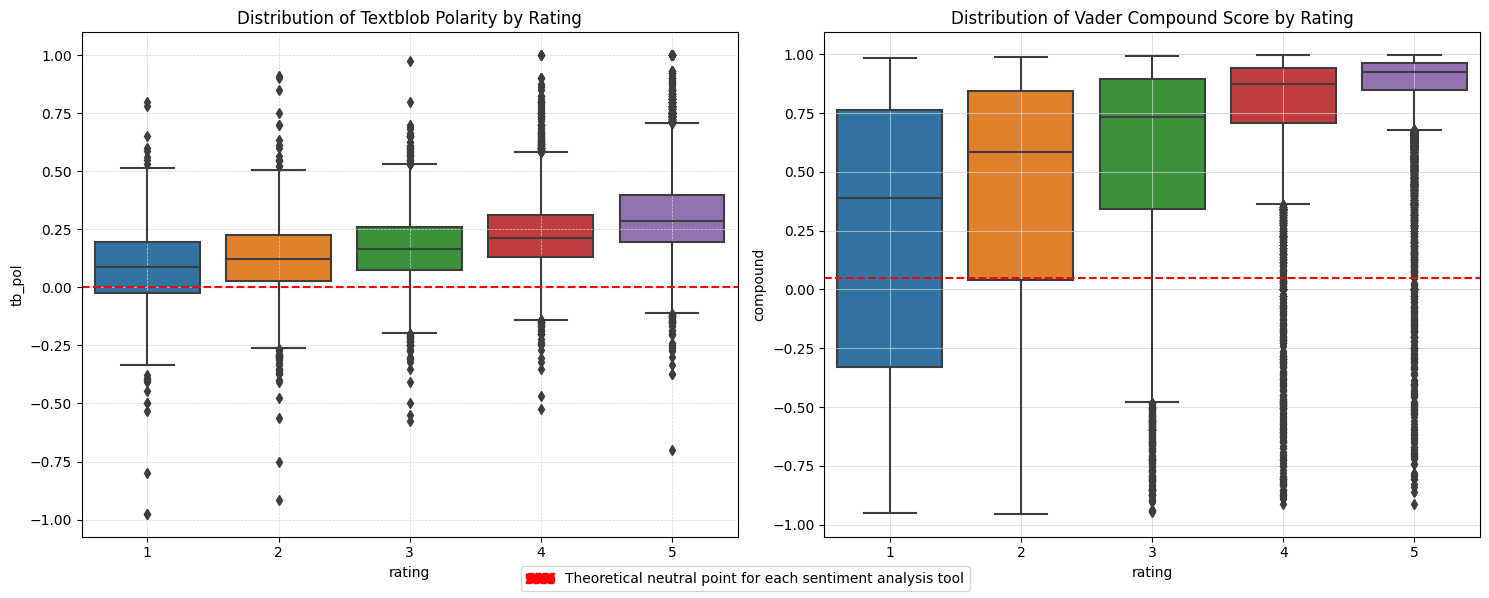

In [45]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['rating'], y=df['tb_pol'])
plt.axhline(0.00, color='red', linestyle='--')  # adds horizontal line at y=0.05 for neutral point

plt.title('Distribution of Textblob Polarity by Rating')
plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, zorder=0) 

plt.subplot(1, 2, 2)
sns.boxplot(x=df['rating'], y=df['compound'])

plt.axhline(0.05, color='red', linestyle='--')  #adds horizontal line at y=0.05 for neutral point
plt.title('Distribution of Vader Compound Score by Rating')
plt.grid(True, color='lightgrey', linestyle='-', linewidth=0.5, which='both', zorder=0) 

plt.subplots_adjust(bottom=0.2) #subplot layout adjusted to make space for the legend below

red_line = mpatches.Patch(color='red', linestyle='--', label='Theoretical neutral point for each sentiment analysis tool')

plt.figlegend(handles=[red_line], loc='lower center', ncol=1)

plt.tight_layout()
plt.show()